## Animal Classifier
Training an image classification using pytorch

In [1]:
import os
from pathlib import Path

import torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.1


### SETUP

In [2]:
# GPU or CPU?
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### DATASET
Load and clean the dataset:
1. Make sure the animals dataset is downloaded into the "datasets/animals" directory
   (https://www.kaggle.com/datasets/npurav/animal-classification-dataset)
2. Add augmented images to the dataset.
3. Load the dataset then split into train and test data

In [3]:
# Get root directory
BASE_DIR = Path.cwd().resolve().parent.parent

# Path to your dataset
dataset_path = BASE_DIR / 'datasets/animals/dataset'

# Define transformations (you can customize these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),
])

# Create ImageFolder dataset
dataset = ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes

In [4]:
# Image augmentation
# Define image transformations for augmentation
augmentation_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),        # Random crop and resize
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    transforms.RandomRotation(degrees=15),    # Random rotation (up to 15 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.1),        # Randomly convert to grayscale
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  # Random perspective
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create augmented dataset
for i in range(10):
    # Apply augmentation to the entire dataset
    augmented_dataset = ImageFolder(dataset_path, transform=augmentation_transform)
    # Combine the original and augmented datasets
    dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])
    
print(f'Total number of images: {len(dataset)}')

Total number of images: 226864


In [5]:
# Split the dataset into training and testing sets
# Change the split ratio as needed (e.g., test_size=0.2 for an 80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f'Total number of training images: {len(trainset)}')
print(f'Total number of test images: {len(testset)}')

Total number of training images: 181491
Total number of test images: 45373


In [6]:
# Create data loaders
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Display a subset of the training images

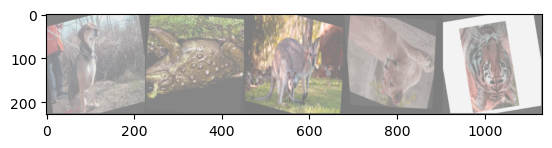

canis-lupus-familiaris telmatobufo-bullocki macropus-giganteus panthera-leo panthera-tigris
CPU times: user 455 ms, sys: 585 ms, total: 1.04 s
Wall time: 4.18 s


In [7]:
%%time

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:5]))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

### TRAINING STEP
Define a convolution neural network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 32, 5)
        # self.fc1 = nn.Linear(32 * 5 * 5, 400)
        self.fc1 = nn.Linear(89888, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=151, bias=True)
)

Define loss function and optimizer

In [9]:
learning_rate = 0.03

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Train the network

In [10]:
%%time
epochs = 2

# Initialize an empty list to store loss values for plotting
loss_values = []
test_loss_values = []
print('Starting Training...')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 200
        if i % step == step - 1:    # print after ever "step" mini-batches
            print(f'epoch({epoch + 1}/{epochs}) batch: {i + 1} loss: {running_loss / step:.3f}')
            # Append the average loss to the list for plotting
            loss_values.append(running_loss / step)
            running_loss = 0.0

    # Calculate test loss after each epoch
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            test_inputs, test_labels = data[0].to(device), data[1].to(device)
            test_outputs = net(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()
    test_loss_values.append(test_running_loss / len(testloader))
    print(f'epoch({epoch + 1}/{epochs}) test loss: {test_running_loss / len(testloader)}')

print('Finished Training')

Starting Training...
epoch(1/2) batch: 200 loss: 4.309
epoch(1/2) batch: 400 loss: 4.131
epoch(1/2) batch: 600 loss: 4.135
epoch(1/2) batch: 800 loss: 4.033
epoch(1/2) batch: 1000 loss: 3.947
epoch(1/2) batch: 1200 loss: 3.878
epoch(1/2) batch: 1400 loss: 3.839
epoch(1/2) batch: 1600 loss: 3.827
epoch(1/2) batch: 1800 loss: 3.797
epoch(1/2) batch: 2000 loss: 3.759
epoch(1/2) batch: 2200 loss: 3.755
epoch(1/2) batch: 2400 loss: 3.717
epoch(1/2) batch: 2600 loss: 3.661
epoch(1/2) batch: 2800 loss: 3.616
epoch(1/2) test loss: 3.5324079018553824
epoch(2/2) batch: 200 loss: 3.566
epoch(2/2) batch: 400 loss: 3.477
epoch(2/2) batch: 600 loss: 3.440
epoch(2/2) batch: 800 loss: 3.390
epoch(2/2) batch: 1000 loss: 3.382
epoch(2/2) batch: 1200 loss: 3.324
epoch(2/2) batch: 1400 loss: 3.314
epoch(2/2) batch: 1600 loss: 3.261
epoch(2/2) batch: 1800 loss: 3.213
epoch(2/2) batch: 2000 loss: 3.119
epoch(2/2) batch: 2200 loss: 3.124
epoch(2/2) batch: 2400 loss: 3.115
epoch(2/2) batch: 2600 loss: 3.094
e

In [11]:
PATH = BASE_DIR / 'models/ac_py.pth'
torch.save(net.state_dict(), PATH)

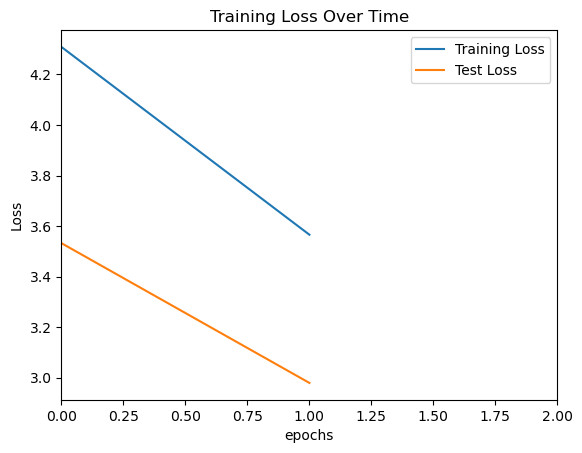

In [12]:
# Plot the loss graph
train_loss_values = []
for i in range(len(loss_values)):
    if i % 14 == 0:
        train_loss_values.append(loss_values[i])
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
custom_x_range = (0, epochs)
plt.xlim(custom_x_range)
plt.show()

### TESTING
Test the trained network on test data

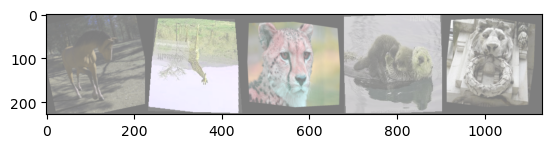

GroundTruth:  equus-caballus giraffa-camelopardalis acinonyx-jubatus enhydra-lutris panthera-leo
CPU times: user 855 ms, sys: 236 ms, total: 1.09 s
Wall time: 8.33 s


In [13]:
%%time

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

In [14]:
# Load the trained model
PATH = BASE_DIR / 'models/ac_py.pth'

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Run tests on a subset of test data

In [15]:
%%time
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}' for j in range(5)))

Predicted:  equus-caballus giraffa-camelopardalis felis-catus dermochelys-coriacea panthera-tigris
CPU times: user 315 ms, sys: 213 ms, total: 528 ms
Wall time: 199 ms


Run test on the entire test data

In [ ]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        if inputs.size()[0] != batch_size:
            break
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Number of test images: {total}')
print(f'Number of correct predictions: {correct}')
print(f'Accuracy of the network on test images: {100 * correct // total} %')

Run test for each class

In [ ]:
%%time
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
            
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')